Generate a graph showing 5v5 rolling CF%, GF%, boxcars, and percentages as in [this tweet](https://twitter.com/muneebalamcu/status/835923952065216512).
<p>First, import relevant packages and routines, and import seaborn to use its nicer-looking default aesthetic settings.

In [1]:
import PbPMethods2 as pm2
from pylab import *
%matplotlib inline
import pandas as pd
import GetPbP
import matplotlib.patheffects as path_effects
import seaborn

Read in game-by-game data from 07-08 to present.

In [2]:
dfs = []
for season in range(2007, 2017):
    dfs.append(pd.read_csv(pm2.get_gamebygame_data_filename(season)))
dfs = pd.concat(dfs)
#dfs.head()

Set parameters:
<ul>
<li>player--player name. You may have to try a few different variations before it works.
<li>player position--D or F
<li>start date and end date--in yyyy-mm-dd format
<li>teams--relevant teams, or "all"
<li>roll length for GF% (and shooting percentage) graph
<li>roll length for CF% graph 
<li>roll length for the boxcar graph
<li>roll length of the TOI and FQoC graphs
<li>boolean for whether to include the playoffs
<li>filename to save to file, or "None" to simply display
<li>boolean for whether to index the x-axis on date (False) or game number (True)--former will result in horizontal lines over July, August, and September, which are a little ugly but make it easy to note offseasons
<li>boolean for whether boxcars should be rate stats or totals


In [3]:
player = "Alex Ovechkin"
pos = 'F'
start_date = '2014-09-15' #use mid-Sept to be safe because some seasons have Euro premiere games
end_date = '2017-06-21' #Format: yyyy-mm-dd

teams = 'all' #or, e.g. {'WSH'}, or {'WSH', 'T.B'}
roll_len_gf = 40 #in games; also applies to sh% and sv%
roll_len_boxcars = 40 
roll_len_cf = 25
roll_len_toi = 10

include_playoffs = True #can also set to False
save_file = None #set to something to save figure
gapless = True #Will avoid long offseason flatlines (no games = no change in CF%)
ratestats = True #will divide by TOI if True
    
if teams == 'all':
    teams = GetPbP.TEAMS
if isinstance(teams, str):
    teams = {teams}

Filters down all the game-by-game data to the one fulfilling the player, team, and date requirements.

In [4]:
df = dfs[dfs.Player == player]
df = df[df.Team.apply(lambda x: x in teams)]

df['Date2'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.sort_values('Date2', inplace=True)
df.set_index('Date2', inplace=True)
df = df.ix[start_date : end_date]

if gapless:
    df.reset_index(inplace=True)

if not include_playoffs:
    df = df[df.Game <= 21230]

Calculate rolling stats

In [5]:
df['{0:d}-game TOION'.format(roll_len_toi)] = df['TOION(60s)'].rolling(window = roll_len_toi, min_periods = 0, center = False).sum()
df['{0:d}-game TOIOFF'.format(roll_len_toi)] = df['TOIOFF(60s)'].rolling(window = roll_len_toi, min_periods = 0, center = False).sum()
df['TOI%'] = df['{0:d}-game TOION'.format(roll_len_toi)]/(df['{0:d}-game TOIOFF'.format(roll_len_toi)] + df['{0:d}-game TOION'.format(roll_len_toi)])
df['{0:d}-game FComp'.format(roll_len_toi)] = df['FComp'].rolling(window=roll_len_toi, min_periods=0, center=False).sum()
df['{0:d}-game F Faced'.format(roll_len_toi)] = df['F Faced'].rolling(window=roll_len_toi, min_periods=0, center=False).sum()
df['FQoC'] = df['{0:d}-game FComp'.format(roll_len_toi)] / df['{0:d}-game F Faced'.format(roll_len_toi)]

In [6]:
base = '{0:d}-game '.format(roll_len_boxcars)

df[base + 'TOI'] = df['TOION(60s)'].rolling(window = roll_len_boxcars, min_periods = 0, center = False).sum()
if ratestats:
    divisor = df[base + 'TOI']
else:
    divisor = 1    

In [7]:
df[base + 'G'] = df['iG'].rolling(window=roll_len_boxcars,min_periods=0,center=False).sum()/divisor
df[base + 'A1'] = df['iA1'].rolling(window=roll_len_boxcars,min_periods=0,center=False).sum()/divisor
df[base + 'A2'] = df['iA2'].rolling(window=roll_len_boxcars,min_periods=0,center=False).sum()/divisor
df[base + 'GFON_box'] = df['GFON'].rolling(window=roll_len_boxcars,min_periods=0,center=False).sum()/divisor

In [8]:
df['{0:d}-game GFON'.format(roll_len_gf)] = df['GFON'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()
df['{0:d}-game GAON'.format(roll_len_gf)] = df['GAON'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()
df['{0:d}-game CFON'.format(roll_len_gf)] = df['CFON'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()
df['{0:d}-game CAON'.format(roll_len_gf)] = df['CAON'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()

df['{0:d}-game CFON'.format(roll_len_cf)] = df['CFON'].rolling(window=roll_len_cf,min_periods=0,center=False).mean()
df['{0:d}-game CAON'.format(roll_len_cf)] = df['CAON'].rolling(window=roll_len_cf,min_periods=0,center=False).mean()
df['{0:d}-game CFOFF'.format(roll_len_cf)] = df['CFOFF'].rolling(window=roll_len_cf,min_periods=0,center=False).mean()
df['{0:d}-game CAOFF'.format(roll_len_cf)] = df['CAOFF'].rolling(window=roll_len_cf,min_periods=0,center=False).mean()

df['{0:d}-game GFOFF'.format(roll_len_gf)] = df['GFOFF'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()
df['{0:d}-game GAOFF'.format(roll_len_gf)] = df['GAOFF'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()
df['{0:d}-game CFOFF'.format(roll_len_gf)] = df['CFOFF'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()
df['{0:d}-game CAOFF'.format(roll_len_gf)] = df['CAOFF'].rolling(window=roll_len_gf,min_periods=0,center=False).mean()

In [9]:
df['GF%'] = df['{0:d}-game GFON'.format(roll_len_gf)] / (df['{0:d}-game GFON'.format(roll_len_gf)] + 
                                                        df['{0:d}-game GAON'.format(roll_len_gf)])
df['GF% Off'] = df['{0:d}-game GFOFF'.format(roll_len_gf)] / (df['{0:d}-game GFOFF'.format(roll_len_gf)] + 
                                                        df['{0:d}-game GAOFF'.format(roll_len_gf)])
df['CF%'] = df['{0:d}-game CFON'.format(roll_len_cf)] / (df['{0:d}-game CFON'.format(roll_len_cf)] + 
                                                        df['{0:d}-game CAON'.format(roll_len_cf)])
df['CF% Off'] = df['{0:d}-game CFOFF'.format(roll_len_cf)] / (df['{0:d}-game CFOFF'.format(roll_len_cf)] + 
                                                        df['{0:d}-game CAOFF'.format(roll_len_cf)])

df['CSh% On'] = df['{0:d}-game GFON'.format(roll_len_gf)] / df['{0:d}-game CFON'.format(roll_len_gf)]
df['CSh% Off'] = df['{0:d}-game GFOFF'.format(roll_len_gf)] / df['{0:d}-game CFOFF'.format(roll_len_gf)]
df['Opp CSh% On'] = df['{0:d}-game GAON'.format(roll_len_gf)] / df['{0:d}-game CAON'.format(roll_len_gf)]
df['Opp CSh% Off'] = df['{0:d}-game GAOFF'.format(roll_len_gf)] / df['{0:d}-game CAOFF'.format(roll_len_gf)]

Helper method for reformatting date stamps.

In [10]:
def format_timestamp_as_mdyy(ts):
    st = str(ts).split(' ')[0]
    y, m, d = st.split('-')
    m = int(m)
    d = int(d)
    return '{0:d}/{1:d}\n{2:s}'.format(m, d, y)

Code to determine when team changes.

In [11]:
indices_to_change_colors = [0]
teamnames = [df['Team'].iloc[0]]
team_annot_x = []
team_annot_y = [0.37]
colors = GetPbP.TEAM_COLOR_DCT[teamnames[0]]
c1 = colors[0]
c2 = colors[1]
color1 = [c1]
color2 = [c2]
next_year_indices = [0]
start_date2 = pd.Timestamp(df['Date2'].iloc[0])
end_date2 = pd.Timestamp(df['Date2'].iloc[-1])
next_year_dates = [format_timestamp_as_mdyy(start_date2)]
years_elapsed = 0
oneyr = pd.Timedelta('365 days')
for i in range(1, len(df)):
    if gapless:
        current_date = df['Date2'].iloc[i]
    else:
        current_date = df.index[i]
    if current_date - start_date2 >= (years_elapsed + 1) * oneyr:
        next_year_indices.append(i)
        next_year_dates.append(format_timestamp_as_mdyy(current_date))
        years_elapsed += 1
    
    if df['Team'].iloc[i] == df['Team'].iloc[i - 1]:
        pass
    else:
        indices_to_change_colors.append(i)
        teamnames.append(df['Team'].iloc[i])
        c1, c2 = GetPbP.TEAM_COLOR_DCT[teamnames[-1]]
        color1.append(c1)
        color2.append(c2)
        
        dt = df.index[indices_to_change_colors[-1] - 1]
        dt = dt - df.index[indices_to_change_colors[-2]]
        
        team_annot_x.append(df.index[indices_to_change_colors[-2]] + dt/2)
        nexty = team_annot_y[0] - team_annot_y[-1] + 0.4
        team_annot_y.append(nexty) #alternate between 0.37 and 0.40
        
indices_to_change_colors.append(len(df))
dt = df.index[-1]
dt = dt - df.index[indices_to_change_colors[-2]]
team_annot_x.append(df.index[indices_to_change_colors[-2]] + dt/2)

Plot.

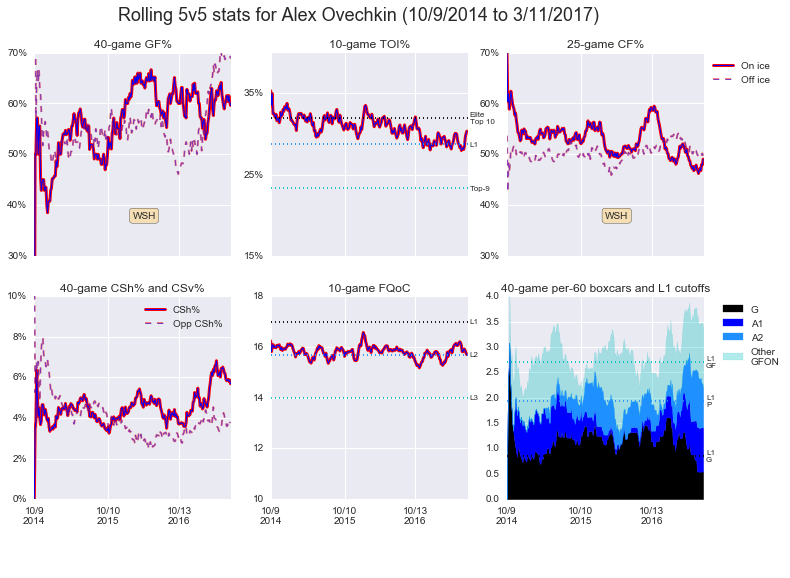

In [12]:
fig, axes = subplots(2, 3, sharex = True, figsize=[12, 8])
gfaxis = axes[0, 0]
toiaxis = axes[0, 1]
cfaxis = axes[0, 2]
cshaxis = axes[1, 0]
qocaxis = axes[1, 1]
boxcaraxis = axes[1, 2]

for i in range(len(indices_to_change_colors) - 1):
    starti = indices_to_change_colors[i]
    endi = indices_to_change_colors[i + 1]
    
    #GF%
    line = gfaxis.plot(df['GF%'].iloc[starti : endi + 1], c=color2[i], 
                lw=1)
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = gfaxis.plot(df['GF% Off'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    gfaxis.annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    #CF%
    line = cfaxis.plot(df['CF%'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='On ice')
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = cfaxis.plot(df['CF% Off'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='Off ice', ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    cfaxis.annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    if i == 0:
        cfaxis.legend(loc=2, bbox_to_anchor=(1, 1), fontsize=10)
    
    #Sh% and Sv%
    line = cshaxis.plot(df['CSh% On'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='CSh%')
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    line = cshaxis.plot(df['Opp CSh% On'].iloc[starti : endi + 1], c=color2[i], 
                lw=1, label='Opp CSh%', ls='--', alpha=0.5)
    line[0].set_path_effects([path_effects.Stroke(linewidth=2, foreground=color1[i]),
                           path_effects.Normal()])
    
    cshaxis.annotate(teamnames[i], xy=(team_annot_x[i], team_annot_y[i]), va='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', edgecolor='black'), fontsize=10)
    if i == 0:
        cshaxis.legend(loc=1, fontsize = 10)
        
    # TOI%
    line = toiaxis.plot(df['TOI%'].iloc[starti : endi + 1], c = color2[i], lw = 1, label = 'TOI%', zorder = 2)
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
    # QoC
    line = qocaxis.plot(df['FQoC'].iloc[starti : endi + 1], c = color2[i], lw = 1, label = 'TOI%', zorder = 2)
    line[0].set_path_effects([path_effects.Stroke(linewidth=3, foreground=color1[i]),
                           path_effects.Normal()])
    
gfaxis.set_ylim(0.3, 0.7)
ys = arange(0.3, 0.71, 0.1)
gfaxis.set_yticks(ys)
gfaxis.set_yticklabels(['{0:.0f}%'.format(y*100) for y in ys])

cfaxis.set_ylim(0.3, 0.7)
cfaxis.set_yticks(ys)
cfaxis.set_yticklabels(['{0:.0f}%'.format(y*100) for y in ys])

if gapless:
    gfaxis.set_xlim(0, len(df))
    gfaxis.set_xticks(next_year_indices)
    gfaxis.set_xticklabels(next_year_dates, ha='left')
    cfaxis.set_xticklabels(next_year_dates, ha='left')
else:
    gfaxis.set_xlim(start_date2, end_date2)
    cfaxis.set_xlim(start_date2, end_date2)

gfaxis.set_title('{0:d}-game GF%'.format(roll_len_gf))
toiaxis.set_title('{0:d}-game TOI%'.format(roll_len_toi))
cfaxis.set_title('{0:d}-game CF%'.format(roll_len_cf))
cshaxis.set_title('{0:d}-game CSh% and CSv%'.format(roll_len_gf))
qocaxis.set_title('{0:d}-game FQoC'.format(roll_len_toi))

if pos == 'D':
    ylow = 0.2
    yhigh = 0.55
else:
    ylow = 0.15
    yhigh = 0.4
toiaxis.set_ylim(ylow, yhigh)
ys = arange(ylow, yhigh + 0.01, 0.1)
toiaxis.set_yticks(ys)
toiaxis.set_yticklabels(['{0:.0f}%'.format(y*100) for y in ys])

# Fill in TOI% benchmarks
if pos == 'D':
    ypos = [.40, .357, .326]
    ytext = ['Elite Top5', 'Top Pair', 'Top-4']
else:
    ypos = [.32, .287, .233]
    ytext = ['Elite\nTop 10', 'L1', 'Top-9']

xlimits = xlim()
tempaxis = toiaxis.twinx()
tempaxis.tick_params(axis='y', which='major', pad=2)
tempaxis.set_yticks(ypos)
tempaxis.set_yticklabels(ytext, fontsize = 8)
tempaxis.grid(b=False)
tempaxis.plot(xlimits, [ypos[0], ypos[0]], color='k', ls=':', zorder = 1)
tempaxis.plot(xlimits, [ypos[1], ypos[1]], color='dodgerblue', ls=':', zorder = 1)
tempaxis.plot(xlimits, [ypos[2], ypos[2]], color='c', ls=':', zorder = 1)
tempaxis.set_ylim(ylow, yhigh)

qocaxis.set_ylim(10, 18)
ys = arange(10, 18.1, 2)
qocaxis.set_yticks(ys)
qocaxis.set_yticklabels([int(y) for y in ys])

# Fill in QoC benchmarks
ypos = [17, 15.7, 14]
ytext = ['L1', 'L2', 'L3']

xlimits = xlim()
tempaxis = qocaxis.twinx()
tempaxis.tick_params(axis='y', which='major', pad=2)
tempaxis.set_yticks(ypos)
tempaxis.set_yticklabels(ytext, fontsize = 8)
tempaxis.grid(b=False)
tempaxis.plot(xlimits, [ypos[0], ypos[0]], color='k', ls=':', zorder = 1)
tempaxis.plot(xlimits, [ypos[1], ypos[1]], color='dodgerblue', ls=':', zorder = 1)
tempaxis.plot(xlimits, [ypos[2], ypos[2]], color='c', ls=':', zorder = 1)
tempaxis.set_ylim(10, 18)

cshaxis.set_ylim(0, 0.1)
ys = arange(0, 0.11, 0.02)
cshaxis.set_yticks(ys)
cshaxis.set_yticklabels(['{0:.0f}%'.format(y*100) for y in ys])


# Boxcars
boxcaraxis.fill_between(df.index, 0, df[base + 'G'], label='G', color='k')
boxcaraxis.fill_between(df.index, df[base + 'G'], df[base + 'G'] + df[base + 'A1'], label='A1', color='b')
boxcaraxis.fill_between(df.index, df[base + 'G'] + df[base + 'A1'], 
                        df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             label='A2', color='dodgerblue')
boxcaraxis.fill_between(df.index, df[base + 'G'] + df[base + 'A1'] + df[base + 'A2'], 
             df[base + 'GFON_box'], label='Other\nGFON', color='c', alpha = 0.3)

axistitle = ''
if ratestats:
    axistitle = '{0:d}-game per-60 boxcars'.format(roll_len_boxcars)
else:
    axistitle = '{0:d}-game boxcars'.format(roll_len_boxcars)
if pos == 'F':
    axistitle += " and L1 cutoffs"
else:
    axistitle += " and P1 cutoffs"
boxcaraxis.set_title(axistitle)

if ratestats:
    if pos == 'F':
        ypos = [0.85, 1.94, 2.7]
        ytext = ['L1\nG', 'L1\nP', 'L1\nGF']
    elif pos == 'D':
        ypos = [0.17, 0.84, 2.5]
        ytext = ['P1\nG', 'P1\nP', 'P1\nGF']
    xlimits = xlim()
    tempaxis = boxcaraxis.twinx()
    tempaxis.tick_params(axis='y', which='major', pad=2)
    tempaxis.set_yticks(ypos)
    tempaxis.set_yticklabels(ytext, fontsize = 8)
    tempaxis.grid(b=False)
    tempaxis.plot(xlimits, [ypos[0], ypos[0]], color='k', ls=':')
    tempaxis.plot(xlimits, [ypos[1], ypos[1]], color='dodgerblue', ls=':')
    tempaxis.plot(xlimits, [ypos[2], ypos[2]], color='c', ls=':')

boxcaraxis.legend(loc=2, bbox_to_anchor=(1.05, 1), fontsize=10)
if ratestats:
    boxcaraxis.set_ylim(0, 4)
    tempaxis.set_ylim(0, 4)
else:
    boxcaraxis.set_ylim(0, top=round(0.75 * roll_len_boxcars))
    tempaxis.set_ylim(0, top=round(0.75 * roll_len_boxcars))
    
titletext = 'Rolling 5v5 stats for {0:s}'.format(player)
titletext += ' ({0:s} to {1:s})'.format(format_timestamp_as_mdyy(start_date2).replace('\n', '/'),
                                       format_timestamp_as_mdyy(end_date2).replace('\n', '/'))
fig.suptitle(titletext, va='top', fontsize=18)

if save_file is not None:
    savefig(save_file, dpi=300)

The code below can be modified as needed to help set cutoffs.

In [13]:
grouped = dfs[['Season', 'Player', 'Pos', 'TOION(60s)', 'TOIOFF(60s)']].groupby(['Season', 'Player', 'Pos']).sum()
grouped.reset_index(inplace = True)
grouped['TOIRank'] = grouped.groupby(['Season', 'Pos']).rank(ascending = False)['TOION(60s)']
grouped = grouped.query("Pos == 'F' & TOIRank <= 360 | Pos == 'D' & TOIRank <= 180")
grouped['TOI%'] = grouped['TOION(60s)'] / (grouped['TOION(60s)'] + grouped['TOIOFF(60s)'])
grouped['TOI60'] = grouped['TOI%'] * 60
grouped['TOI60Rank'] = grouped.groupby(['Season', 'Pos']).rank(ascending = False)['TOI60']
grouped.head()

,Season,Player,Pos,TOION(60s),TOIOFF(60s),TOIRank,TOI%,TOI60,TOI60Rank
3,2007,Aaron Miller,D,12.981944,27.078611,163.0,0.324058,19.443481,120.0
5,2007,Aaron Voros,F,7.566389,36.440000,351.0,0.171938,10.316305,347.0
6,2007,Aaron Ward,D,17.959444,34.282778,105.0,0.343773,20.626356,82.0
8,2007,Adam Burish,F,11.085833,45.559167,277.0,0.195707,11.742431,330.0
9,2007,Adam Foote,D,23.564167,37.511944,20.0,0.385816,23.148985,12.0


In [14]:
grouped.query('Pos == "F" & TOI60Rank % 90 == 0').groupby('TOI60Rank').mean()

,Season,TOION(60s),TOIOFF(60s),TOIRank,TOI%,TOI60
TOI60Rank,,,,,,
90.0,2011.5,16.041833,39.699361,126.9,0.287493,17.249578
180.0,2011.5,16.068694,44.629361,129.9,0.264700,15.882006
270.0,2011.5,12.546833,41.142722,233.9,0.233738,14.024265
360.0,2011.5,8.035083,48.972389,344.2,0.141452,8.487093
